# ANALISIS EXPLICATIVO DE DATOS DE COBRANZA

#### Autor: Andrea Rodríguez
#### Fecha: Septiembre 2025
#### Descripción: Análisis exploratorio y visual de múltiples fuentes de datos de clientes, comportamiento financiero y castigos, para apoyar modelos de riesgo.

In [2]:
# CARGA DE LIBRERIAS

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import LabelEncoder
import os

In [3]:
# CARGA DE DATOS

user_dir = "/Users/.../"

# Cargar múltiples fuentes de datos
cliente = pd.read_csv(os.path.join(user_dir, "1 Informacion Sociodemografica.csv"))
econ = pd.read_csv(os.path.join(user_dir, "2. Información Económica.csv"))
buro = pd.read_excel(os.path.join(user_dir, "3. Diccionario Tabla Información Buro de crédito.xlsx"))
prod = pd.read_csv(os.path.join(user_dir, '4. Informacion de Producto.txt'), delimiter='|')
com = pd.read_csv(os.path.join(user_dir, '5. Informacion Comportamiento.txt'), delimiter='|')
pago = pd.read_csv(os.path.join(user_dir, '6 Informacion de Pagos.csv')) 
ree = pd.read_csv(os.path.join(user_dir, '8. Informacion de Reestructuraciones (Por producto).txt'), delimiter='|')
cas = pd.read_csv(os.path.join(user_dir, '9. Informacion Castigos2.txt'), delimiter='|')
ges = pd.read_csv(os.path.join(user_dir, '10 Gestiones.txt'), delimiter='|')

/var/folders/1l/rbnylnzs30d_ld5x_j18dzym6g1fqt/T/ipykernel_3461/669270434.py:10: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  com = pd.read_csv(os.path.join(user_dir, '5. Informacion Comportamiento.txt'), delimiter='|')


In [4]:
# FUNCIONES UTILIZADAS

def convertir_columnas_fecha(df):
    """
    Convierte todas las columnas cuyo nombre comienza con 'FECHA' (insensible a mayúsculas)
    a tipo datetime.
    """
    for col in df.columns:
        if col.upper().startswith("FECHA"):
            try:
                df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
                print(f"Columna convertida: {col}")
            except Exception as e:
                print(f"No se pudo convertir {col}: {e}")
    return df


def analizar_serie_temporal(df, fecha_col, valor_col, freq='M'):
    """
    Realiza una descomposición temporal para detectar tendencia y estacionalidad.
    """
    df = df[[fecha_col, valor_col]].dropna()
    df = df.set_index(fecha_col).resample(freq).sum()

    descomposicion = seasonal_decompose(df, model='additive')
    descomposicion.plot()
    plt.suptitle(f'{fecha_col} - Descomposición temporal de {valor_col}')
    plt.tight_layout()
    plt.show()


def correlaciones(df, columnas_numericas):
    """
    Genera un mapa de calor de correlaciones entre variables numéricas.
    """
    corr = df[columnas_numericas].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', annot_kws={"size": 8}, fmt=".2f")
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title("Correlación entre variables", fontsize=12)
    plt.tight_layout()
    plt.show()


def convertir_a_numerico_hot_n(df):
    """
    Convierte variables categóricas en numéricas usando One-Hot Encoding.
    """
    columnas_no_numericas = df.select_dtypes(include=['object', 'string', 'category']).columns
    df_codificado = pd.get_dummies(df, columns=columnas_no_numericas, drop_first=True, dtype=int)
    return df_codificado

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414148 entries, 0 to 414147
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   FOLADE                   414148 non-null  int64         
 1   NEGOCIO                  414148 non-null  int64         
 2   TIPO DE PERSONA          414148 non-null  object        
 3   FECHA VINCULACION        185589 non-null  datetime64[ns]
 4   ESTADO CLIENTE           414144 non-null  object        
 5   FECHA NACIMIENTO         413885 non-null  datetime64[ns]
 6   SEXO                     414145 non-null  object        
 7   PROFESION                300435 non-null  object        
 8   ESTADO CIVIL             301120 non-null  object        
 9   CARGO                    301120 non-null  object        
 10  NIVEL ACADEMICO          300912 non-null  object        
 11  DEPENDIENTES ECONOMICOS  414148 non-null  int64         
 12  TIPO VIVIENDA   

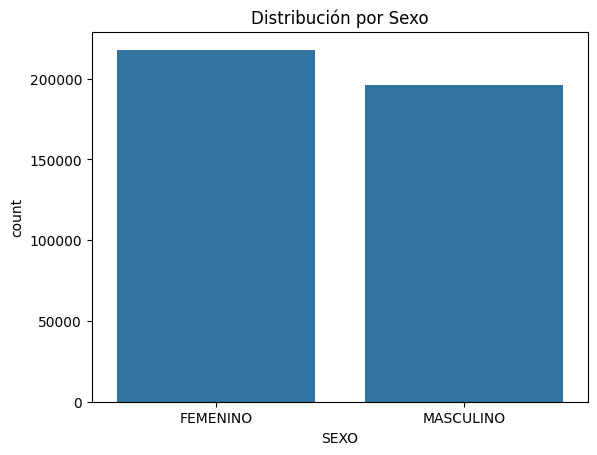

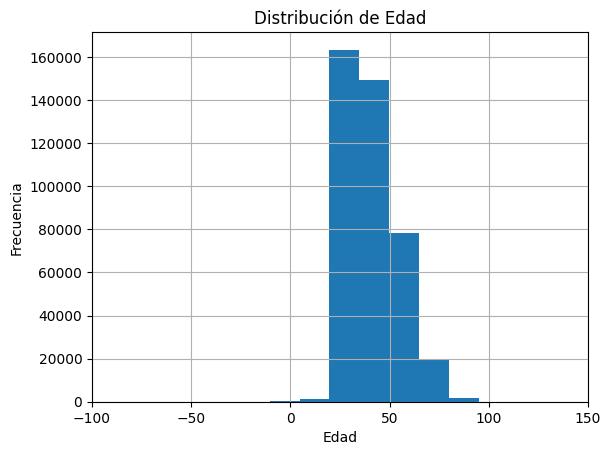

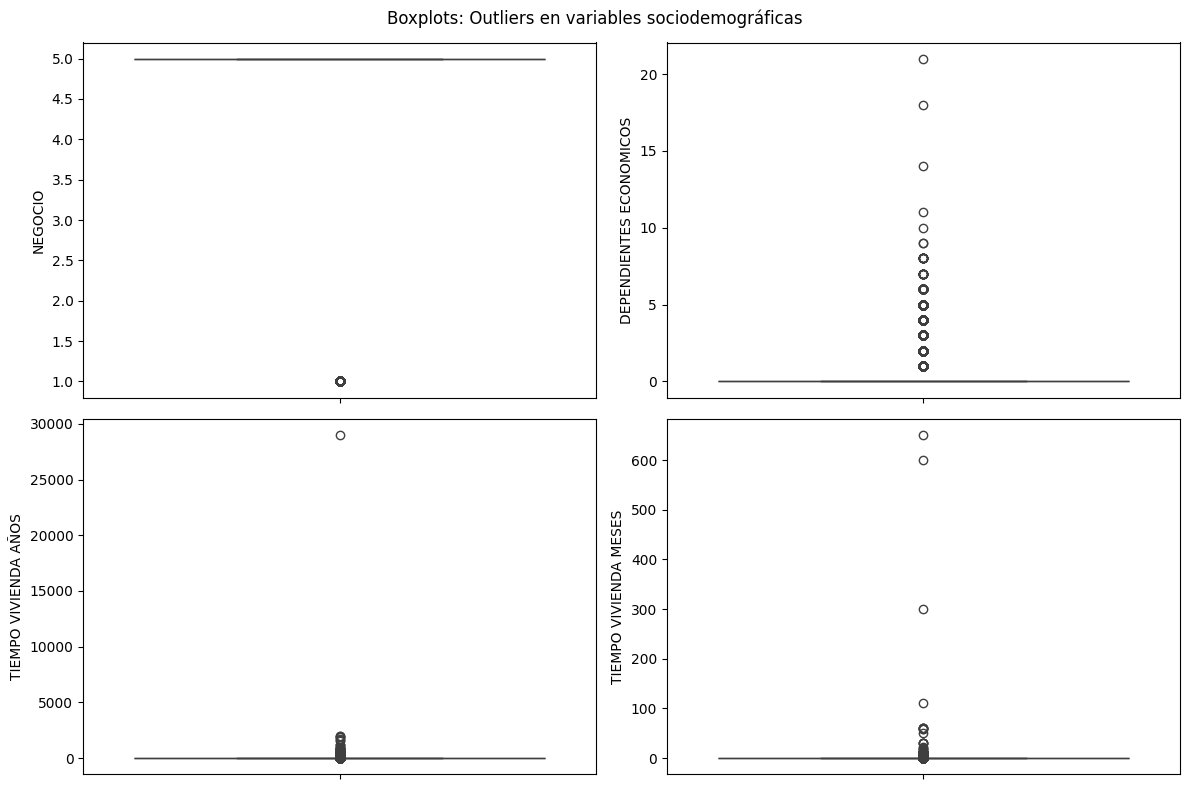

/var/folders/1l/rbnylnzs30d_ld5x_j18dzym6g1fqt/T/ipykernel_3461/1068275955.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.set_index(fecha_col).resample(freq).sum()


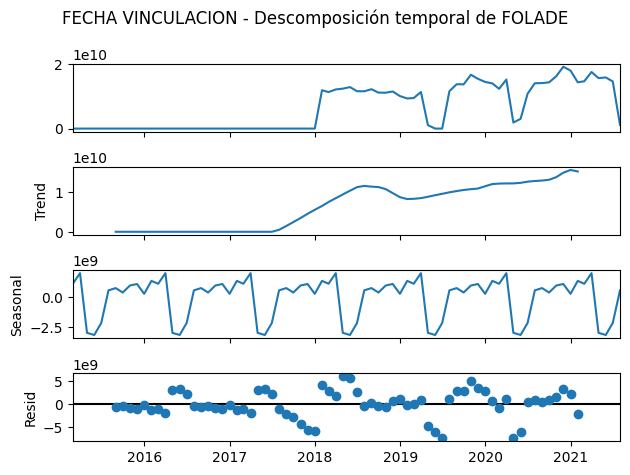

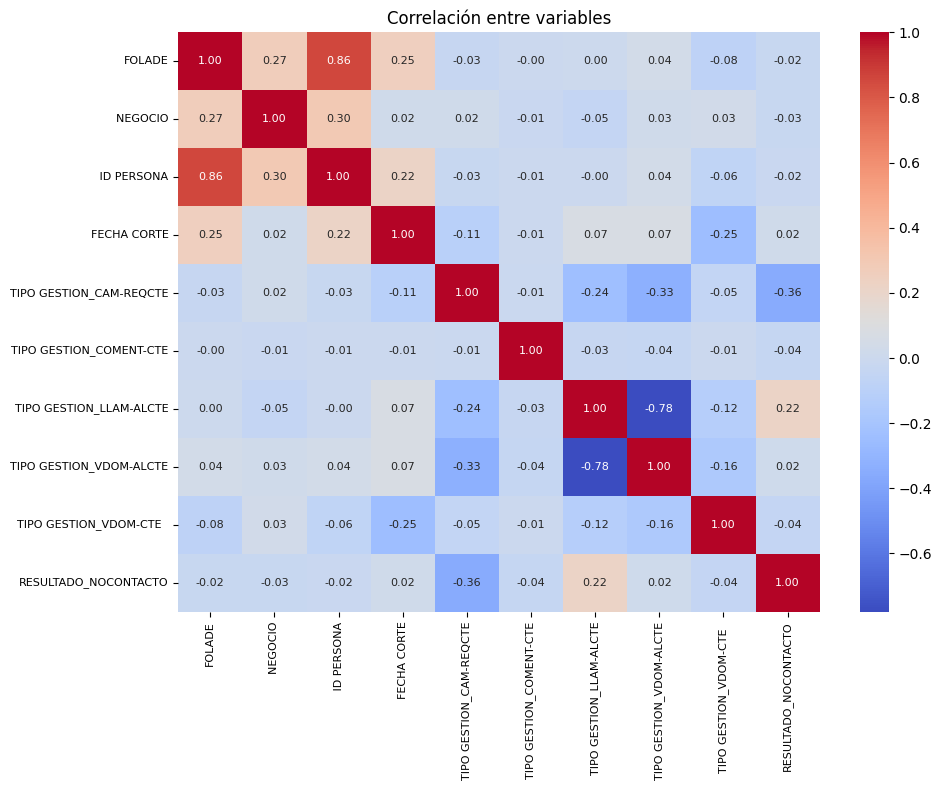

In [ ]:
# EJEMPLO DE USO

# INFORMACIÓN GENERAL
cliente.info()

# Corrección de tipo de dato fechas
convertir_columnas_fecha(cliente)

# Cálculo de edad
cliente['Edad'] = pd.to_datetime('today').year - cliente['FECHA NACIMIENTO'].dt.year

# Gráfico de distribución de sexo
sns.countplot(x='SEXO', data=cliente)
plt.title('Distribución por Sexo')
plt.show()

# Histograma de edad
cliente['Edad'].hist(bins=20)
plt.title('Distribución de Edad')
plt.xlabel('Edad')
plt.xlim(-100, 150)
plt.ylabel('Frecuencia')
plt.show()


#VISUALIZACION DE OUTLIERS
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plt.suptitle('Boxplots: Outliers en variables sociodemográficas')

sns.boxplot(y=cliente['NEGOCIO'], ax=axes[0,0])
sns.boxplot(y=cliente['DEPENDIENTES ECONOMICOS'], ax=axes[0,1])
sns.boxplot(y=cliente['TIEMPO VIVIENDA ANIOS'], ax=axes[1,0])
sns.boxplot(y=cliente['TIEMPO VIVIENDA MESES'], ax=axes[1,1])

axes[1,0].set_ylabel("TIEMPO VIVIENDA AÑOS")
plt.tight_layout()
plt.show()


#SERIE TEMPORAL

# Asegurar que las fechas estén en datetime
#cliente['FECHA VINCULACION'] = pd.to_datetime(cliente['FECHA VINCULACION'], dayfirst=True, errors='coerce')

# Crear columna dummy para contar afiliaciones
#cliente['FOLADE'] = 1

# Analizar serie temporal de vinculaciones
analizar_serie_temporal(cliente, 'FECHA VINCULACION', 'FOLADE', freq='M')


#IDENTIFICACIONES DE PATRONES CON CORRELACION

# Convertir variables categóricas a numéricas para análisis
ges_encoded = convertir_a_numerico_hot_n(ges)

# Ver columnas para analizar correlación
columnas_correlacion = ges_encoded.columns.tolist()

# Mostrar matriz de correlación
correlaciones(ges_encoded, columnas_correlacion)
